In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
import os
from sklearn.utils.class_weight import compute_class_weight
import pickle
import importlib
from tensorflow.keras.applications.densenet import preprocess_input

# define class list
class_list = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

TARGET_SIZE = (224,224)
AUGMENTATION_BATCH_SIZE = 32 # must be less than the minimum number of samples in a class
BATCH_SIZE = 16 # training
RANDOM_SEED = 42
EPOCHS = 20 # reduced from 50 because of augmentation



In [2]:
# mount google drive where preprocessed images are
# Mount drive and download data from EDA step 1
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
## create directory in virtual environment
# this takes about 3 mins, please be patient
VDIR_PROJECT = '/content/skin_cancer/training'
os.makedirs(VDIR_PROJECT, exist_ok=True)


# define source directory from Gdrive
GDIR_PROJECT_EDA_S1 = '/content/drive/MyDrive/AAI-521/Module7/TeamProject/EDA_PrePro/S1'

# Copy S1 onto virtual env
#!cp -r {GDIR_PROJECT_EDA_S1}/* {VDIR_PROJECT}

# COPY
dataset_filename = 'S1_images.zip'
GDIR_DATASET_ZIPPED = os.path.join(GDIR_PROJECT_EDA_S1, dataset_filename)
!cp -r {GDIR_DATASET_ZIPPED} {VDIR_PROJECT}

# unzip
!unzip {VDIR_PROJECT}/{dataset_filename} -d {VDIR_PROJECT}/

Streaming output truncated to the last 5000 lines.
  inflating: /content/skin_cancer/training/train/nv/ISIC_0028720.jpg  
  inflating: /content/skin_cancer/training/train/nv/ISIC_0024895.jpg  
  inflating: /content/skin_cancer/training/train/nv/ISIC_0032198.jpg  
  inflating: /content/skin_cancer/training/train/nv/ISIC_0033346.jpg  
  inflating: /content/skin_cancer/training/train/nv/ISIC_0031035.jpg  
  inflating: /content/skin_cancer/training/train/nv/ISIC_0024401.jpg  
  inflating: /content/skin_cancer/training/train/nv/ISIC_0031863.jpg  
  inflating: /content/skin_cancer/training/train/nv/ISIC_0028248.jpg  
  inflating: /content/skin_cancer/training/train/nv/ISIC_0027791.jpg  
  inflating: /content/skin_cancer/training/train/nv/ISIC_0033036.jpg  
  inflating: /content/skin_cancer/training/train/nv/ISIC_0025786.jpg  
  inflating: /content/skin_cancer/training/train/nv/ISIC_0026151.jpg  
  inflating: /content/skin_cancer/training/train/nv/ISIC_0034073.jpg  
  inflating: /content/skin

In [4]:
VDIR_PROJECT_VAL = VDIR_PROJECT + "/val"
VDIR_PROJECT_TRAIN = VDIR_PROJECT + "/train"

In [5]:
# function that generates augmented images in target dir (on colab, make sure target_dir is on virtual env)
TARGET_NUMSAMPLES_PER_CLASS = 6000
def generate_augmented_images(source_dir, target_dir, target_count, target_class, target_size=(224,224), batch_size = 64):

  # source_dir: basis of generation of augmented images, must contain subdirectories with different classes
  # target_dir: where all augmented images and base images are saved, a subdirectory will be created for the specified target_class
  #
  # target_count: required number of images per target_class
  # target_class: Image Data Generator will only consider images from the specified target_class

  # uses global BATCH_SIZE and TARGET_SIZE variables
  print("\tTARGET_CLASS: ", target_class)
  # initialize image data generator
  # many of the the configuratios below are from (1)
  datagen = ImageDataGenerator(
    rotation_range = 25, # as per (1)
    width_shift_range=0.15, # as per (1)
    height_shift_range=0.15, # as per (1)
    zoom_range=0.1, # arbitrarily chosen
    shear_range=0.15, # (1)
    horizontal_flip=True, #(1)
    vertical_flip=True, #(1)
    brightness_range=(0.9,1.5), #(1)
    fill_mode='nearest') # keras default

  print("\tSOURCE DIR: ", source_dir)

  print("\tTARGET_COUNT: ", target_count)

  # create target directory for this class
  target_dir = os.path.join(target_dir, target_class)
  if not os.path.exists(target_dir):
    os.makedirs(target_dir, exist_ok = True)
  print("\tTARGET DIR: ", target_dir)

  # apply image data generator above on source_dir
  aug_generator = datagen.flow_from_directory(
    source_dir,
    seed=42,
    save_to_dir=target_dir,
    save_format='jpg',
    target_size=target_size,
    batch_size=batch_size,
    classes=[target_class])

  # count number of batches needed to generate augmented images for this class
  num_base_images = len(os.listdir(source_dir+'/'+target_class))
  print("\tNUM BASE IMAGES: ", num_base_images)

  num_aug_images_wanted = target_count - num_base_images
  if(num_aug_images_wanted < 0): num_aug_images_wanted = 0
  print("\tNUM AUG IMAGES NEEDED: ", num_aug_images_wanted)

  num_batches = int(np.ceil(num_aug_images_wanted / batch_size))
  print("\tNUM BATCHES: ", num_batches)

  # call generator enough number of times to generate/save desired number of images
  for i in range(0, num_batches):
    #print(f"i:{i}", end='/r')
    if(i%10==0):
      print(f"\tBatch No: {i}", flush=True)
    #time.sleep(1.0)
    next(aug_generator)

  return

In [6]:
# create folders in virtual environment to save augmented images into
VDIR_PROJECT_TRAIN_AUG = VDIR_PROJECT+'/train_aug'
#VDIR_PROJECT_VAL_AUG = VDIR_PROJECT+'/val_aug'
os.makedirs(VDIR_PROJECT_TRAIN_AUG, exist_ok = True)
#os.makedirs(VDIR_PROJECT_VAL_AUG, exist_ok = True)


In [7]:
# generate augmented images so there is around the same number of images per class. save on virtual env only
source_dir = VDIR_PROJECT_TRAIN
target_dir = VDIR_PROJECT_TRAIN_AUG

for idx, dx_type in enumerate(class_list):
  print(f"dx_type: {dx_type}")
  generate_augmented_images(source_dir, target_dir,
                            target_count = TARGET_NUMSAMPLES_PER_CLASS,
                            target_class = dx_type,
                            target_size=TARGET_SIZE, batch_size=AUGMENTATION_BATCH_SIZE)

dx_type: akiec
	TARGET_CLASS:  akiec
	SOURCE DIR:  /content/skin_cancer/training/train
	TARGET_COUNT:  6000
	TARGET DIR:  /content/skin_cancer/training/train_aug/akiec
Found 297 images belonging to 1 classes.
	NUM BASE IMAGES:  297
	NUM AUG IMAGES NEEDED:  5703
	NUM BATCHES:  179
	Batch No: 0
	Batch No: 10
	Batch No: 20
	Batch No: 30
	Batch No: 40
	Batch No: 50
	Batch No: 60
	Batch No: 70
	Batch No: 80
	Batch No: 90
	Batch No: 100
	Batch No: 110
	Batch No: 120
	Batch No: 130
	Batch No: 140
	Batch No: 150
	Batch No: 160
	Batch No: 170
dx_type: bcc
	TARGET_CLASS:  bcc
	SOURCE DIR:  /content/skin_cancer/training/train
	TARGET_COUNT:  6000
	TARGET DIR:  /content/skin_cancer/training/train_aug/bcc
Found 479 images belonging to 1 classes.
	NUM BASE IMAGES:  479
	NUM AUG IMAGES NEEDED:  5521
	NUM BATCHES:  173
	Batch No: 0
	Batch No: 10
	Batch No: 20
	Batch No: 30
	Batch No: 40
	Batch No: 50
	Batch No: 60
	Batch No: 70
	Batch No: 80
	Batch No: 90
	Batch No: 100
	Batch No: 110
	Batch No: 120
	

In [8]:
# count number of images per class in augmented folder
print("TRAIN_AUGMENTED:")
for dx_type in class_list.keys():#metadata_df_train['dx'].unique():
  print(dx_type, len(os.listdir(VDIR_PROJECT_TRAIN_AUG+'/'+dx_type)))

TRAIN_AUGMENTED:
akiec 5337
bcc 5525
bkl 4940
df 4954
mel 4868
nv 224
vasc 4772


In [9]:
print("TRAIN:")
for dx_type in class_list.keys():#metadata_df_train['dx'].unique():
  print(dx_type, len(os.listdir(VDIR_PROJECT_TRAIN+'/'+dx_type)))

TRAIN:
akiec 297
bcc 479
bkl 1003
df 107
mel 1065
nv 5784
vasc 129


In [10]:
# copy images from train into augmented train folder
!cp -r {VDIR_PROJECT_TRAIN}/* {VDIR_PROJECT_TRAIN_AUG}/

In [11]:
print("TRAIN_AUGMENTED:")
for dx_type in class_list.keys():#metadata_df_train['dx'].unique():
  print(dx_type, len(os.listdir(VDIR_PROJECT_TRAIN_AUG+'/'+dx_type)))

TRAIN_AUGMENTED:
akiec 5634
bcc 6004
bkl 5943
df 5061
mel 5933
nv 6008
vasc 4901


In [12]:
# zip the final augmented train images
# change root dir to OUTPUT DIR for zipping
%cd {VDIR_PROJECT}/

# zip train and val folders into one dir
!zip -r S1_images_withAug.zip train_aug/

Streaming output truncated to the last 5000 lines.
  adding: train_aug/df/_88_6859469.jpg (deflated 2%)
  adding: train_aug/df/_34_1629127.jpg (deflated 2%)
  adding: train_aug/df/_94_4975771.jpg (deflated 2%)
  adding: train_aug/df/_69_2504628.jpg (deflated 3%)
  adding: train_aug/df/_102_6676907.jpg (deflated 2%)
  adding: train_aug/df/_92_602357.jpg (deflated 3%)
  adding: train_aug/df/_102_6913173.jpg (deflated 2%)
  adding: train_aug/df/_94_3974443.jpg (deflated 2%)
  adding: train_aug/df/_19_1734607.jpg (deflated 2%)
  adding: train_aug/df/_100_9922814.jpg (deflated 2%)
  adding: train_aug/df/_62_4061783.jpg (deflated 2%)
  adding: train_aug/df/_99_5931856.jpg (deflated 2%)
  adding: train_aug/df/_36_3475782.jpg (deflated 2%)
  adding: train_aug/df/_35_9566406.jpg (deflated 2%)
  adding: train_aug/df/_68_1117871.jpg (deflated 2%)
  adding: train_aug/df/_100_8797259.jpg (deflated 2%)
  adding: train_aug/df/_11_5894162.jpg (deflated 5%)
  adding: train_aug/df/_6_7753195.jpg (deflat

In [ ]:
!cp -r {VDIR_PROJECT}/S1_images.zip {GDIR_PROJECT_EDA_S1}

In [13]:
# create image iterators
# preprocess input according to DenseNet's preprocessing function
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# create train dataset generator based on augmented train directory
train_generator = datagen.flow_from_directory(
    VDIR_PROJECT_TRAIN_AUG,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode = 'categorical',
    seed = RANDOM_SEED)


# create validation dataset generator
val_generator = datagen.flow_from_directory(
    VDIR_PROJECT_VAL,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode = 'categorical',
    seed = RANDOM_SEED)



Found 39484 images belonging to 7 classes.
Found 1094 images belonging to 7 classes.


In [14]:
# Compute class weights
classes = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weight_dict = dict(enumerate(class_weights))
class_weight_dict



{0: 1.0011663877478574,
 1: 0.9394689254782526,
 2: 0.9491118001971106,
 3: 1.1145171761650718,
 4: 0.9507115166983698,
 5: 0.9388434468327944,
 6: 1.1509021482496284}

In [15]:
# Access the class to integer mapping
class_list = train_generator.class_indices

# Print the mapping
print(class_list)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [16]:
# define pipeline function, requires tf

def fine_tune_DenseNet_on_skin_cancer_images(
    target_size = (TARGET_SIZE[0], TARGET_SIZE[1], 3),
    model_name = 'default',
    DenseNet_model = tf.keras.applications.DenseNet121,
    train_generator = [], # ImageDataGenerator that uses DenseNet Preprocess function
    val_generator = [], # ImageDataGenerator that uses DenseNet Preprocess function
    class_weight_dict =[], # class bias during classifier fitting.
    epochs = 50,
    save_dir = [] # where to save model, history
    ):

  #base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
  base_model = DenseNet_model(weights='imagenet', include_top=False, input_shape=target_size)

  # Freeze the base model layers
  base_model.trainable = False

  # Create a classifier model on top of the base model
  model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(500, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  # Use 'softmax' for multi-class classification
  ])

  # compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[categorical_accuracy])

  # print model summary
  #base_model.summary()
  #model.summary()

  # train model
  history = model.fit(
    train_generator,
    class_weight=class_weight_dict,
    validation_data=val_generator,
    epochs=epochs, verbose=1)

  # save model and history in virtual drive
  save_model(save_dir, model_name, model, history)

  # return model and history history
  return model, history

In [17]:
# define a function that saves the model weights, training history in the virtual environment
def save_model(TARGET_DIR, model_name="default", model=[], history=[]):
  # check if model exists already to avoid overwriting previous ones
  model_path = TARGET_DIR + '/'+model_name
  if os.path.exists(model_path) and os.path.isdir(model_path):
    print("Folder exists, exiting")
    return
  else:
    print(f"Saving model and training history in :{model_path}")
    os.makedirs(model_path, exist_ok=True)

  model.save(model_path+'/model.keras')
  with open(model_path+'/training_history.pkl', 'wb') as file:
    pickle.dump(history, file)

  return

In [18]:
VDIR_PROJECT_MODELS = VDIR_PROJECT+'/models'
os.makedirs(VDIR_PROJECT_MODELS, exist_ok=True)

In [19]:
model121_v3, history121_v3 = fine_tune_DenseNet_on_skin_cancer_images(
    target_size = (TARGET_SIZE[0],TARGET_SIZE[1], 3),
    model_name = 'DenseNet121_v3',
    DenseNet_model = tf.keras.applications.DenseNet121,
    train_generator = train_generator, # ImageDataGenerator that uses DenseNet Preprocess function
    val_generator = val_generator, # ImageDataGenerator that uses DenseNet Preprocess function
    class_weight_dict = class_weight_dict, # class bias during classifier fitting.
    epochs = EPOCHS,
    save_dir = VDIR_PROJECT_MODELS # where to save model, history
    )

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2468/2468 ━━━━━━━━━━━━━━━━━━━━ 152s 52ms/step - categorical_accuracy: 0.5282 - loss: 1.2363 - val_categorical_accuracy: 0.8300 - val_loss: 0.4560
Epoch 2/20
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 106s 43ms/step - categorical_accuracy: 0.6420 - loss: 0.9125 - val_categorical_accuracy: 0.8446 - val_loss: 0.4342
Epoch 3/20
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 106s 43ms/step - categorical_accuracy: 0.6793 - loss: 0.8267 - val_categorical_accuracy: 0.8437 - val_loss: 0.4294
Epoch 4/20
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 106s 43ms/step - categorical_accuracy: 0.6975 - loss: 0.7687 - val_categorical_accuracy: 0.8510 - val_loss: 0.4154
Epoch 5/20
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 106s 43ms/step - categorical_accuracy: 0.7144 - loss: 0.7288 - val_categorical_accuracy: 0.8611 - val_loss: 0.4263
Epoch 6/20
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 107s 43ms/step - categorical_accuracy: 0.7232 - loss: 0.7097 - val_categorical_accuracy: 0.8519 - val_loss: 0.4323
Epoch 7/20
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 106s 43ms/step - categorica

In [20]:
# copy evaluation_functions.py from gdrive to current working directory
GDIR_PROJECT_COMMON_FUNCTIONS = '/content/drive/MyDrive/AAI-521/Module7/TeamProject/Common_Functions'

!cp -r {GDIR_PROJECT_COMMON_FUNCTIONS}/* ./

In [21]:
import evaluation_functions as ef
importlib.reload(ef)

evaluation_functions version: 0.0.3 is loaded.

evaluation_functions version: 0.0.3 is loaded.



<module 'evaluation_functions' from '/content/skin_cancer/training/evaluation_functions.py'>

Available Metrics1: ['categorical_accuracy', 'loss']

Here1: metrics: ['categorical_accuracy' 'loss']

Metrics to display: ['categorical_accuracy' 'loss']

Num Rows:  1
plotA 0 train/val curves for metric categorical_accuracy

plotA 1 train/val curves for metric loss



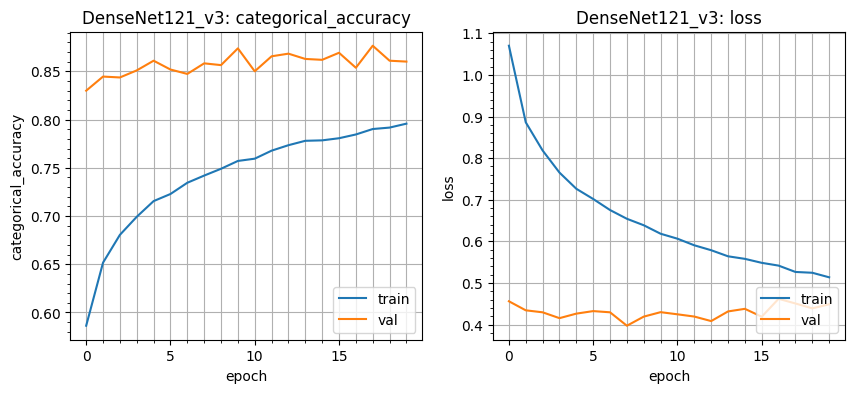

Found 1094 files belonging to 7 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step
              precision    recall  f1-score   support

       akiec       0.50      0.47      0.48        30
         bcc       0.60      0.51      0.55        35
         bkl       0.54      0.57      0.55        86
          df       0.43      0.38      0.40         8
         mel       0.32      0.35      0.33        46
          nv       0.95      0.95      0.95       876
        vasc       0.89      0.62      0.73        13

    accuracy                           0.86      1094
   macro avg       0.60      0.55      0.57      1094
weighted avg       0.86      0.86      0.86      1094



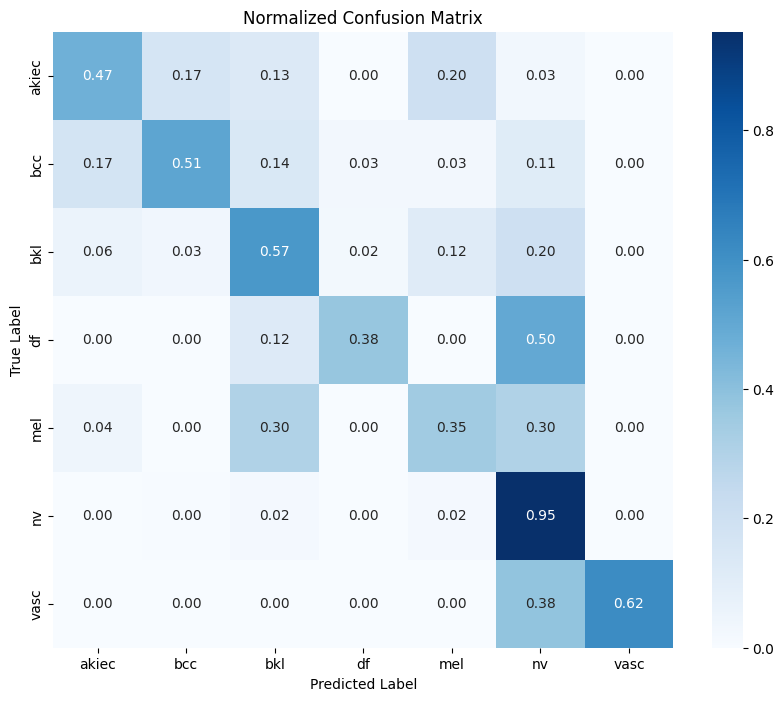

In [22]:
# EVALUATE
ef.group5_evaluate(VDIR_PROJECT_VAL, model=model121_v3,
                   model_name='DenseNet121_v3',
                   class_list =class_list,
                   training_history = history121_v3,
                   batch_size=BATCH_SIZE,
                   image_size = TARGET_SIZE)

In [23]:
# Save model to GDRIVE
GDIR_PROJECT_TRAINING = '/content/drive/MyDrive/AAI-521/Module7/TeamProject/Training/'
os.makedirs(GDIR_PROJECT_TRAINING, exist_ok=True)

In [24]:
# copy training results from virtual to gdrive
!cp -r {VDIR_PROJECT_MODELS} {GDIR_PROJECT_TRAINING}

In [25]:
fine_tune_DenseNet_on_skin_cancer_images(
    target_size = (TARGET_SIZE[0],TARGET_SIZE[1], 3),
    model_name = 'DenseNet169_v3',
    DenseNet_model = tf.keras.applications.DenseNet169,
    train_generator = train_generator, # ImageDataGenerator that uses DenseNet Preprocess function
    val_generator = val_generator, # ImageDataGenerator that uses DenseNet Preprocess function
    class_weight_dict = class_weight_dict, # class bias during classifier fitting.
    epochs = EPOCHS,
    save_dir = VDIR_PROJECT_MODELS # where to save model, history
    )

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 193s 67ms/step - categorical_accuracy: 0.5456 - loss: 1.2015 - val_categorical_accuracy: 0.8355 - val_loss: 0.4474
Epoch 2/20
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 137s 56ms/step - categorical_accuracy: 0.6670 - loss: 0.8468 - val_categorical_accuracy: 0.8455 - val_loss: 0.4381
Epoch 3/20
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 137s 55ms/step - categorical_accuracy: 0.7008 - loss: 0.7602 - val_categorical_accuracy: 0.8565 - val_loss: 0.4180
Epoch 4/20
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 137s 56ms/step - categorical_accuracy: 0.7183 - loss: 0.7097 - val_categorical_accuracy: 0.8601 - val_loss: 0.4234
Epoch 5/20
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 137s 55ms/step - categorical_accuracy: 0.7338 - loss: 0.6787 - val_categorical_accuracy: 0.8537 - val_loss: 0.4434
Epoch 6/20
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 137s 55ms/step - categorical_accuracy: 0.7422 - loss: 0.6558 - val_categorical_accuracy: 0.8675 - val_loss: 0.4246
Epoch 7

(<Sequential name=sequential_1, built=True>,
 <keras.src.callbacks.history.History at 0x7b8222033940>)

In [26]:
fine_tune_DenseNet_on_skin_cancer_images(
    target_size = (TARGET_SIZE[0],TARGET_SIZE[1], 3),
    model_name = 'DenseNet201_v3',
    DenseNet_model = tf.keras.applications.DenseNet201,
    train_generator = train_generator, # ImageDataGenerator that uses DenseNet Preprocess function
    val_generator = val_generator, # ImageDataGenerator that uses DenseNet Preprocess function
    class_weight_dict = class_weight_dict, # class bias during classifier fitting.
    epochs = EPOCHS,
    save_dir = VDIR_PROJECT_MODELS # where to save model, history
    )

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/20
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 241s 85ms/step - categorical_accuracy: 0.5620 - loss: 1.1605 - val_categorical_accuracy: 0.8473 - val_loss: 0.4477
Epoch 2/20
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 174s 71ms/step - categorical_accuracy: 0.6884 - loss: 0.7977 - val_categorical_accuracy: 0.8336 - val_loss: 0.4794
Epoch 3/20
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 174s 70ms/step - categorical_accuracy: 0.7107 - loss: 0.7335 - val_categorical_accuracy: 0.8720 - val_loss: 0.4037
Epoch 4/20
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 173s 70ms/step - categorical_accuracy: 0.7370 - loss: 0.6715 - val_categorical_accuracy: 0.8629 - val_loss: 0.4150
Epoch 5/20
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 174s 70ms/step - categorical_accuracy: 0.7522 - loss: 0.6276 - val_categorical_accuracy: 0.8647 - val_loss: 0.4200
Epoch 6/20
2468/2468 ━━━━━━━━━━━━━━━━━━━━ 174s 70ms/step - categorical_accuracy: 0.7588 - loss: 0.6036 - val_categorical_accuracy: 0.8675 - val_loss: 0.4105
Epoch 7

(<Sequential name=sequential_2, built=True>,
 <keras.src.callbacks.history.History at 0x7b8221314df0>)

In [27]:
# copy training results from virtual to gdrive
!cp -r {VDIR_PROJECT_MODELS} {GDIR_PROJECT_TRAINING}

In [ ]:
# define function that loads model weights (keras) & history (pickle)

def load_model_history_keras(models_dir, model_name):
  model_path = models_dir+'/'+model_name+'/model.keras'
  history_path = models_dir+'/'+model_name+'/training_history.pkl'

  model = tf.keras.models.load_model(model_path)
  with open(history_path, 'rb') as file:
    history = pickle.load(file)

  return model, history


Available Metrics1: ['categorical_accuracy', 'loss']

Here1: metrics: ['categorical_accuracy' 'loss']

Metrics to display: ['categorical_accuracy' 'loss']

Num Rows:  1
plotA 0 train/val curves for metric categorical_accuracy

plotA 1 train/val curves for metric loss



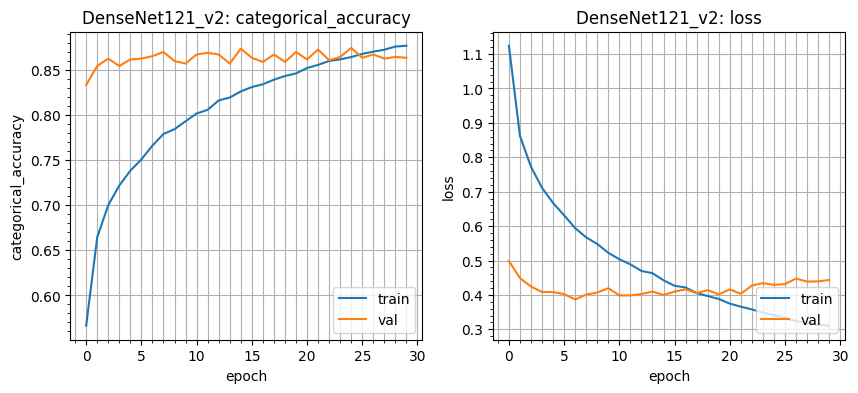

Found 1094 files belonging to 7 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step
              precision    recall  f1-score   support

       akiec       0.42      0.37      0.39        30
         bcc       0.56      0.57      0.56        35
         bkl       0.55      0.52      0.54        86
          df       0.50      0.38      0.43         8
         mel       0.38      0.43      0.40        46
          nv       0.95      0.95      0.95       876
        vasc       0.91      0.77      0.83        13

    accuracy                           0.86      1094
   macro avg       0.61      0.57      0.59      1094
weighted avg       0.86      0.86      0.86      1094



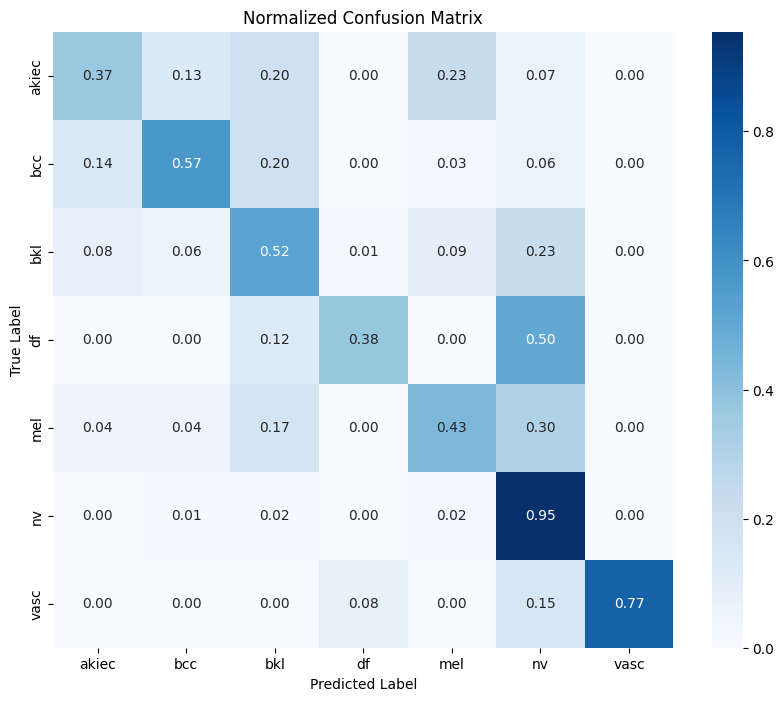

Available Metrics1: ['categorical_accuracy', 'loss']

Here1: metrics: ['categorical_accuracy' 'loss']

Metrics to display: ['categorical_accuracy' 'loss']

Num Rows:  1
plotA 0 train/val curves for metric categorical_accuracy

plotA 1 train/val curves for metric loss



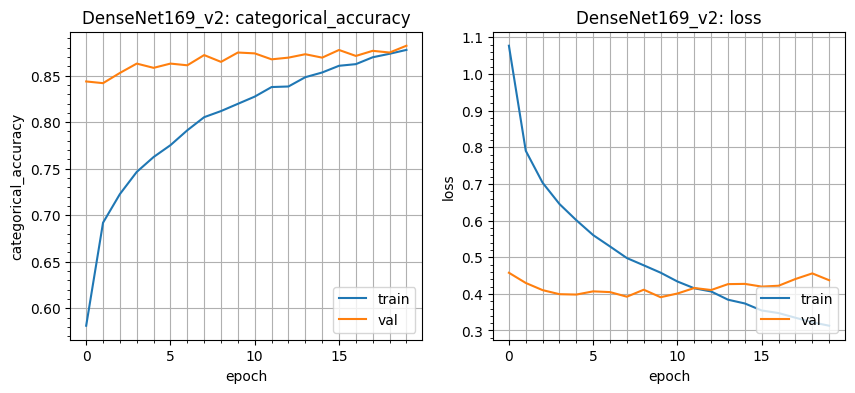

Found 1094 files belonging to 7 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step
              precision    recall  f1-score   support

       akiec       0.60      0.40      0.48        30
         bcc       0.59      0.54      0.57        35
         bkl       0.63      0.60      0.62        86
          df       0.50      0.50      0.50         8
         mel       0.43      0.41      0.42        46
          nv       0.95      0.96      0.96       876
        vasc       0.73      0.85      0.79        13

    accuracy                           0.88      1094
   macro avg       0.63      0.61      0.62      1094
weighted avg       0.87      0.88      0.88      1094



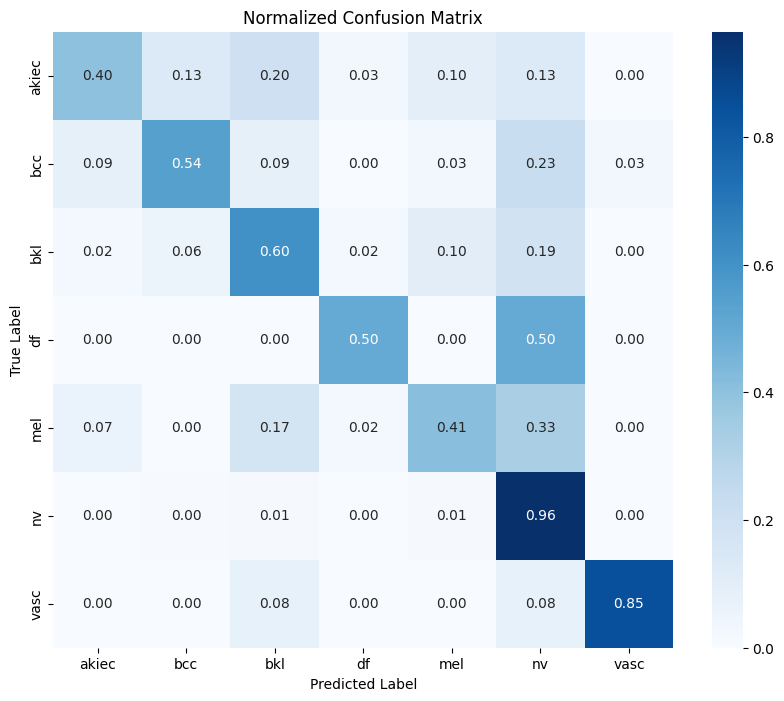

Available Metrics1: ['categorical_accuracy', 'loss']

Here1: metrics: ['categorical_accuracy' 'loss']

Metrics to display: ['categorical_accuracy' 'loss']

Num Rows:  1
plotA 0 train/val curves for metric categorical_accuracy

plotA 1 train/val curves for metric loss



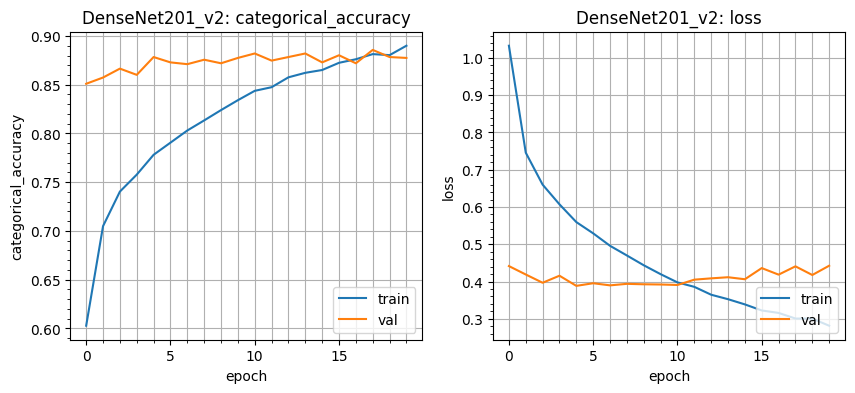

Found 1094 files belonging to 7 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 8s/step
              precision    recall  f1-score   support

       akiec       0.43      0.30      0.35        30
         bcc       0.55      0.60      0.58        35
         bkl       0.71      0.66      0.69        86
          df       0.40      0.50      0.44         8
         mel       0.42      0.35      0.38        46
          nv       0.95      0.96      0.95       876
        vasc       0.69      0.69      0.69        13

    accuracy                           0.88      1094
   macro avg       0.59      0.58      0.58      1094
weighted avg       0.87      0.88      0.87      1094



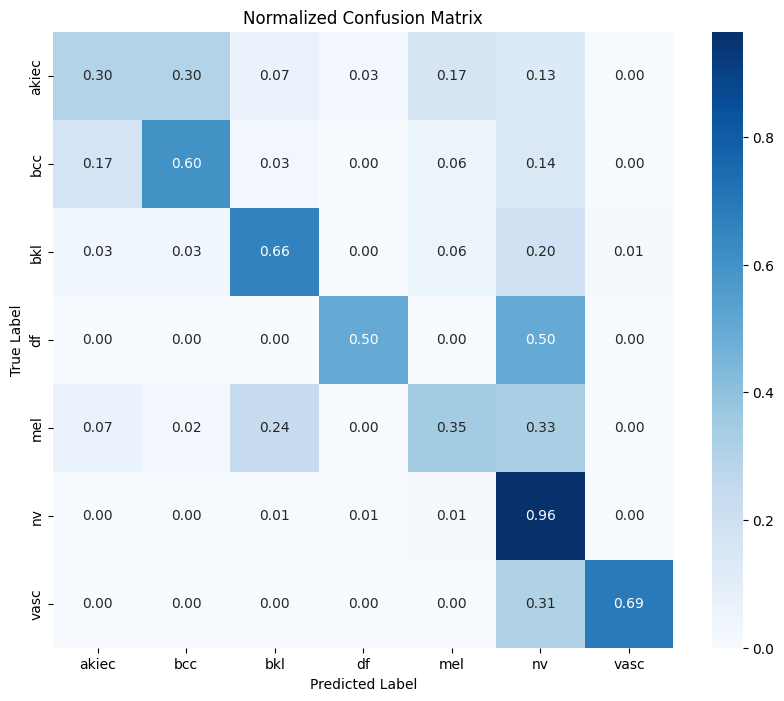

In [ ]:
models_names = ['DenseNet121_v2', 'DenseNet169_v2', 'DenseNet201_v2']
models = [[] for i in range (len(models_names))]
histories = [[] for i in range (len(models_names))]

# load models and histories to evaluate
for i in range(len(models_names)):
  model, history = load_model_history_keras(VDIR_PROJECT_MODELS, models_names[i])
  models[i] = model
  histories[i] = history

  # evaluate
  ef.group5_evaluate(VDIR_PROJECT_VAL,
                     model=model,
                     model_name=models_names[i],
                     class_list =class_list,
                     training_history = history,
                     batch_size=256,
                     image_size = (224,224))
